In [1]:
#cell1 (running about 10 mins; GPU needed)
#How to change GPU: 1.Click right-top option button. 2.Choose "Change Run Time Type". 3.Choose GPU (T4 GPU or A100 GPU)

!pip install git+https://github.com/facebookresearch/sam2.git ipycanvas --quiet
from google.colab import files, output
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
from ipywidgets import Image as IPYImage
import numpy as np
from ipycanvas import MultiCanvas
from IPython.display import display
from io import BytesIO
import ipywidgets as widgets
import matplotlib.pyplot as plt

output.enable_custom_widget_manager()
predictor = SAM2ImagePredictor.from_pretrained(
    "facebook/sam2-hiera-large", mask_threshold=0.0
)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sam2_hiera_large.pt:   0%|          | 0.00/898M [00:00<?, ?B/s]

In [2]:
#cell2 (Click "Choose Files" Button and upload file)
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
pil_image_obj = Image.open(filename)
image_np = np.array(pil_image_obj.convert("RGB"))
predictor.set_image(image_np)

Saving Rectangle 37_30.png to Rectangle 37_30.png


In [3]:
#cell3 (Click directly on object/image; The Dot Color is Green)
dot_radius = 8
dot_color = "lime"
overlay_guide_alpha = 0.3
grid_size = 50
w, h = pil_image_obj.size
f = BytesIO()
pil_image_obj.save(f, format='PNG')
f.seek(0)
image_widget = IPYImage(
    value=f.read(),
    format='png',
    width=w,
    height=h,
)
canvases = MultiCanvas(2, width=w, height=h)
display(canvases)
base, overlay = canvases[0], canvases[1]
base.draw_image(image_widget, 0, 0)
overlay.global_alpha = 0.5
overlay.fill_style = dot_color
points = []
def on_mouse_down(x, y):
    points.append((x, y))
    overlay.fill_circle(x, y, dot_radius)
overlay.on_mouse_down(on_mouse_down)
print(f"Canvas dimensions (W, H): {w}, {h}")
print(f"Type of object drawn: {type(pil_image_obj)} (converted to {type(image_widget)})")

MultiCanvas(height=853, width=1280)

Canvas dimensions (W, H): 1280, 853
Type of object drawn: <class 'PIL.PngImagePlugin.PngImageFile'> (converted to <class 'ipywidgets.widgets.widget_media.Image'>)


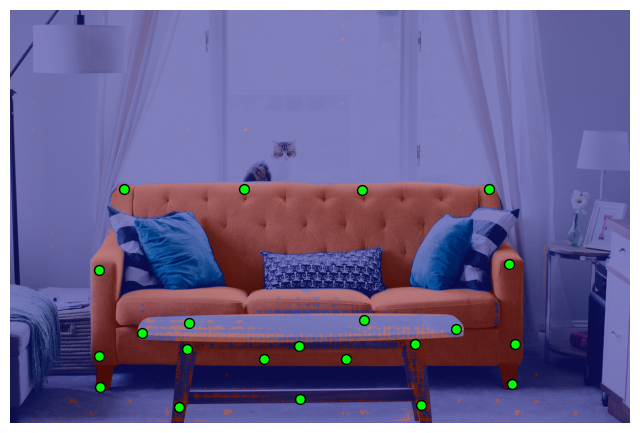

/tmp/ipython-input-1791962678.py:30: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_rgba_image = Image.fromarray(rgba, mode="RGBA")


In [4]:
# Cell 4
# Run SAM-2 and Visualize Results
coords = np.array(points)
labels = np.ones(len(points), dtype=int)
masks, scores, _ = predictor.predict(
    point_coords=coords,
    point_labels=labels,
    multimask_output=False
)

plt.figure(figsize=(8,8))
plt.imshow(image_np)
plt.imshow(masks[0], cmap="jet", alpha=0.5)
for (x, y), l in zip(coords, labels):
    plt.scatter(x, y, c="lime", s=50, edgecolors="black")
plt.axis("off")
plt.show()

alpha = (masks[0] > 0.5).astype(np.uint8) * 255

if image_np.ndim == 3 and image_np.shape[2] == 3:
    rgba = np.dstack([image_np, alpha])
elif image_np.ndim == 3 and image_np.shape[2] == 4:
    rgba = image_np.copy()
    rgba[:,:,3] = alpha
else:
    print("Warning: image_np has unexpected shape for compositing RGBA. Check input.")
    rgba = np.dstack([np.zeros_like(image_np), alpha])

pil_rgba_image = Image.fromarray(rgba, mode="RGBA")
background_color = (255, 255, 255)
background = Image.new('RGB', pil_rgba_image.size, background_color)
result = Image.alpha_composite(background.convert('RGBA'), pil_rgba_image).convert('RGB')

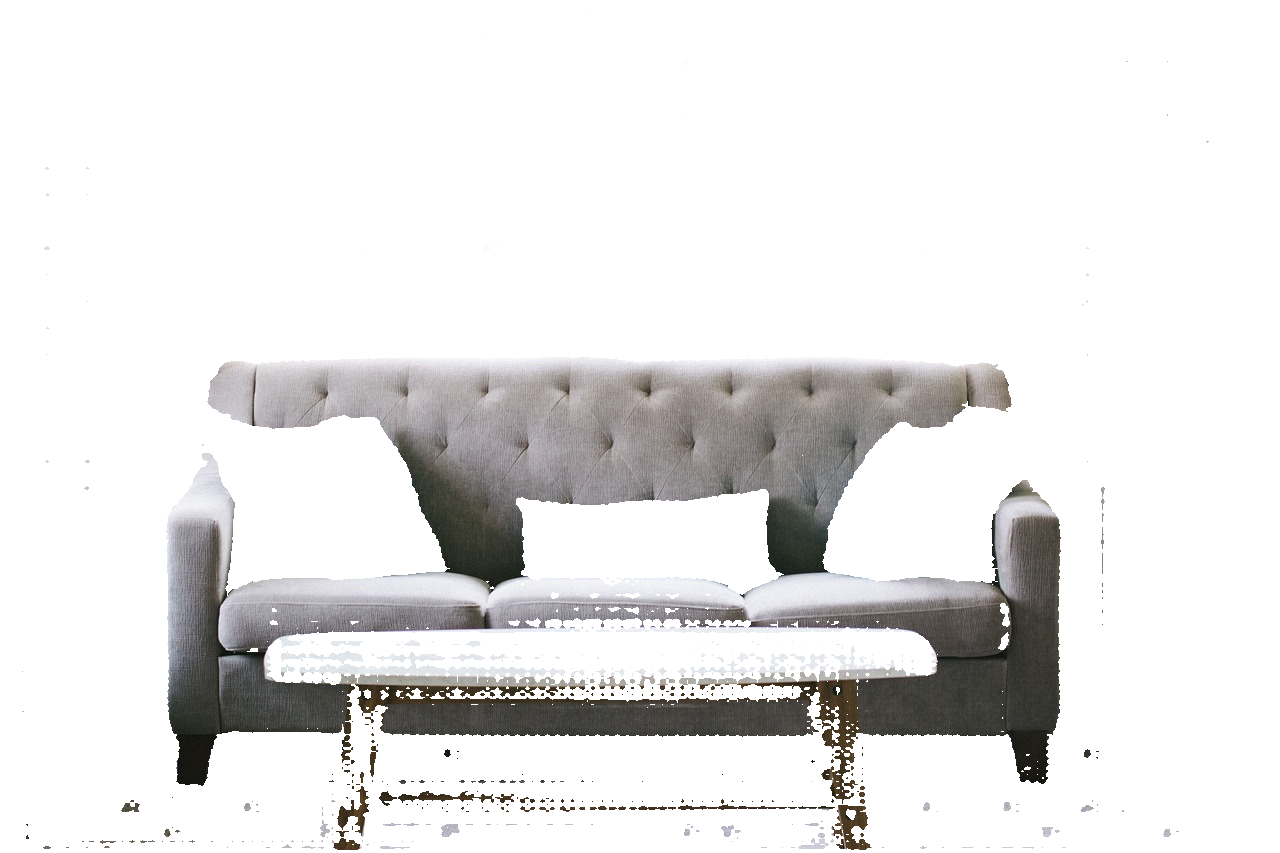

✅ Saved cutout to Colab files as sam2_Rectangle 37_30.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Initiating download for sam2_Rectangle 37_30.png...


In [5]:
# Cell 5: Saving and Direct Download
display(result)
out_name = "sam2_" + filename.rsplit(".", 1)[0] + ".png"
result.save(out_name)
print(f"✅ Saved cutout to Colab files as {out_name}")
files.download(out_name)
print(f"⬇️ Initiating download for {out_name}...")